In [1]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

/home/lukas/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Model and tokenizer
model_name = 'siebert/sentiment-roberta-large-english'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, output_hidden_states=True)
model.eval()

/home/lukas/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

In [3]:
# Load the dataset
dataset = load_dataset('go_emotions')

# Select a subset of 2000 samples from the 'train' split
subset_size = 2000
data = dataset['train'].shuffle(seed=42)#.select(range(subset_size))

In [4]:
# Extract texts and labels
texts = data['text']
labels = data['labels']  # Multi-labels (list of lists)

In [5]:
# Simplify labels to the first label
single_labels = [label[0] if label else -1 for label in labels]

# Filter out samples without labels
filtered_texts = [text for text, label in zip(texts, single_labels) if label != -1]
filtered_labels = [label for label in single_labels if label != -1]

print(f"Number of samples after filtering: {len(filtered_texts)}")

Number of samples after filtering: 43410


In [6]:
filtered_texts

['I would say they do because it was a horrible accident but they were also in the wrong. The military tried to get them to disperse they didnt.',
 'Done, good luck with your thing.',
 'Now, this is epic! ',
 'Eat better.',
 'So you stay on your theft from auto waiting for them to dispatch the next shift to the backlog of calls.',
 "Glad to hear it's ubiquitous and not an OS thing.",
 'Now we’re wishing death on 15 year old kids? Keep setting the bar lower please',
 'Oh so it is a separate guy filming, it’s actually impressive how synced up their speeds are',
 "Yes. I got accused of being a man or a bootlicker because I was a mod in a men's lib sub two years ago.",
 'Get big, whatever it takes.',
 'It’s amazing what they can justify to themselves. I’m not sure if I can believe anything out of her mouth anymore.',
 "Calm down. It's a real concept.",
 'Wow, what a controversial opinion.',
 "If I have to watch Canada lose in a shootout I'm gonna lose it",
 'what time is it now? i’m defini

In [8]:
def get_embeddings(text_list, tokenizer, model):
    embeddings = []
    batch_size = 16 
    check = batch_size*50
    with torch.no_grad():
        for i in range(0, len(text_list), batch_size):
            batch_texts = text_list[i:i+batch_size]
            inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt', max_length=128)
            outputs = model(**inputs, output_hidden_states=True)

            hidden_states = outputs.hidden_states  # Tuple of tensors

            embe = []
            for last_hidden_state in hidden_states:
                # Mean pooling
                attention_mask = inputs['attention_mask'].unsqueeze(-1)  # Shape: (batch_size, seq_length, 1)
                masked_hidden_state = last_hidden_state * attention_mask
                sum_embeddings = torch.sum(masked_hidden_state, dim=1)
                sum_mask = torch.sum(attention_mask, dim=1)
                embedding = sum_embeddings / sum_mask  # Shape: (batch_size, hidden_size)
                embe.append(embedding.unsqueeze(0))
            embedding = torch.cat(embe, dim=0)
            embeddings.append(embedding)
            
            if i % check == 0:
                print(f"Processed {i + len(batch_texts)}/{len(text_list)} samples")
    embeddings = torch.cat(embeddings, dim=1)
    return embeddings


In [9]:
embeddings = get_embeddings(filtered_texts, tokenizer, model)
print(f"Embeddings shape: {embeddings.shape}")

Processed 16/43410 samples
Processed 816/43410 samples
Processed 1616/43410 samples
Processed 2416/43410 samples
Processed 3216/43410 samples
Processed 4016/43410 samples
Processed 4816/43410 samples
Processed 5616/43410 samples
Processed 6416/43410 samples
Processed 7216/43410 samples
Processed 8016/43410 samples
Processed 8816/43410 samples
Processed 9616/43410 samples
Processed 10416/43410 samples
Processed 11216/43410 samples
Processed 12016/43410 samples
Processed 12816/43410 samples
Processed 13616/43410 samples
Processed 14416/43410 samples
Processed 15216/43410 samples
Processed 16016/43410 samples
Processed 16816/43410 samples
Processed 17616/43410 samples
Processed 18416/43410 samples
Processed 19216/43410 samples
Processed 20016/43410 samples
Processed 20816/43410 samples
Processed 21616/43410 samples
Processed 22416/43410 samples
Processed 23216/43410 samples
Processed 24016/43410 samples
Processed 24816/43410 samples
Processed 25616/43410 samples
Processed 26416/43410 samp

In [10]:
embeddings.shape

torch.Size([25, 43410, 1024])

In [41]:
embeddings_normed = embeddings/torch.norm(embeddings, dim = 2, keepdim=True)
embeddings_np = embeddings_normed.cpu().numpy()

In [46]:
embe = embeddings.numpy()
mean_vector = np.mean(embe, axis=0)
embeddings_centered = embe - mean_vector

In [7]:
# save the embeddings
# np.save('embeddings_full.npy', embeddings_np)
# embeddings_np = np.load('embeddings.npy')
# np.save('embeddings_centered_full.npy', embeddings_centered)
# embeddings_centered = np.load('embeddings_centered_full.npy')

In [42]:
embeddings_np[-1,].shape, embeddings_np[-1,]

((2000, 1024),
 array([[ 1.25303818e-02,  1.96042880e-02, -1.12052923e-02, ...,
          2.58679204e-02, -3.16167139e-02,  2.66390406e-02],
        [-1.15190074e-03, -4.69375309e-03, -1.75988954e-02, ...,
          3.48453945e-03, -1.32906297e-03, -2.74753693e-04],
        [-7.22732453e-04, -4.85300971e-03, -1.79409552e-02, ...,
          3.85062094e-03, -3.26699740e-03,  2.38084886e-03],
        ...,
        [-1.33973523e-03, -4.48209047e-03, -1.75061487e-02, ...,
          4.73444629e-03,  4.48443694e-03, -1.10436045e-02],
        [ 1.43979695e-02,  1.96156725e-02, -9.37551074e-03, ...,
          3.02970726e-02, -2.79762875e-02,  2.47535612e-02],
        [-1.41983270e-03, -4.57493216e-03, -1.75843984e-02, ...,
          3.35428515e-03, -1.59525056e-03, -1.50078467e-05]], dtype=float32))

Here I guess we would need spherical PCA. Normalization and playning on Euclidean space doesn't bring anything so one really needs some factors over sphere?

In [66]:
from sklearn.decomposition import PCA

n_components = 5  # Number of components to keep
principal_components = []
for i in range(0, 25, 1):
    pca = PCA(n_components=n_components)
    principal_components.append(pca.fit_transform(embeddings_np[i, ]))

principal_components

[array([[-0.27669463,  0.08849088,  0.09387277, -0.08449893, -0.01348187],
        [ 0.17212044,  0.10104491, -0.00052011,  0.00878053, -0.03641738],
        [ 0.24576555,  0.0507353 ,  0.04376037,  0.00861509, -0.08051047],
        ...,
        [-0.10184368,  0.11939228, -0.06623095, -0.03132407,  0.11743607],
        [ 0.30088955,  0.0938658 ,  0.08059809, -0.03063328, -0.05310097],
        [-0.0990515 ,  0.10741884, -0.07537832,  0.04654432,  0.02047889]],
       dtype=float32),
 array([[ 0.12675849, -0.02547963, -0.00810097, -0.00028365,  0.02676902],
        [-0.08086774, -0.0568956 ,  0.02644268,  0.01608964,  0.01912298],
        [-0.14408903, -0.01330728, -0.01992461,  0.03173035,  0.0547026 ],
        ...,
        [ 0.01123646, -0.04930208, -0.02740325,  0.07119995,  0.08427518],
        [-0.12099469, -0.04389524,  0.08066167,  0.01231847,  0.00852735],
        [ 0.0578514 , -0.02422166,  0.00625065,  0.0191484 ,  0.04245842]],
       dtype=float32),
 array([[ 0.140716  , -0.0

In [63]:
#explained_variance = pca.explained_variance_ratio_
#for i, var in enumerate(explained_variance):
#    print(f'PC{i+1} explains {var*100:.2f}% of the variance')

PC1 explains 58.35% of the variance
PC2 explains 19.94% of the variance
PC3 explains 9.29% of the variance
PC4 explains 6.22% of the variance
PC5 explains 1.48% of the variance
PC6 explains 1.28% of the variance
PC7 explains 0.31% of the variance
PC8 explains 0.21% of the variance
PC9 explains 0.14% of the variance


In [72]:
# Create a DataFrame
pc_columns = [f'HU{j+1} PC{i+1}' for j in range(25) for i in range(n_components) ]
pc_df = pd.DataFrame(np.concat(principal_components, axis = 1), columns=pc_columns)
pc_df['Emotion_Label'] = filtered_labels

# Get emotion names from the dataset
emotion_names = dataset['train'].features['labels'].feature.names

# Map labels to names
pc_df['Emotion_Name'] = pc_df['Emotion_Label'].apply(lambda x: emotion_names[x])


In [73]:
pc_df

HU1 PC1   HU1 PC2   HU1 PC3   HU1 PC4   HU1 PC5   HU2 PC1   HU2 PC2  \
0    -0.276695  0.088491  0.093873 -0.084499 -0.013482  0.126758 -0.025480   
1     0.172120  0.101045 -0.000520  0.008781 -0.036417 -0.080868 -0.056896   
2     0.245766  0.050735  0.043760  0.008615 -0.080510 -0.144089 -0.013307   
3     0.436254  0.010511  0.184039  0.012044 -0.017411 -0.177308 -0.087643   
4    -0.230832  0.101062  0.016238 -0.035994 -0.099940  0.091686 -0.043926   
...        ...       ...       ...       ...       ...       ...       ...   
1995  0.009476 -0.082919 -0.170709 -0.071476 -0.067633  0.025373  0.093726   
1996 -0.225472  0.049028  0.002902 -0.027080 -0.072486  0.117226 -0.001097   
1997 -0.101844  0.119392 -0.066231 -0.031324  0.117436  0.011236 -0.049302   
1998  0.300890  0.093866  0.080598 -0.030633 -0.053101 -0.120995 -0.043895   
1999 -0.099051  0.107419 -0.075378  0.046544  0.020479  0.057851 -0.024222   

       HU2 PC3   HU2 PC4   HU2 PC5  ...  HU24 PC3  HU24 PC4  HU24 PC5  \
0    -0.008101 -0.000284  0.026769  ... -0.071402  0.058666  0.009835   
1     0.026443  0.016090  0.019123  ...  0.141159 -0.025273  0.007027   
2    -0.019925  0.031730  0.054703  ...  0.065623 -0.048917 -0.007254   
3     0.050911 -0.049914  0.004396  ...  0.103856 -0.036762  0.002754   
4     0.012208  0.005139  0.000376  ... -0.090588  0.134275 -0.046809   
...        ...       ...       ...  ...       ...       ...       ...   
1995  0.074863  0.064379  0.038463  ... -0.451571 -0.094162 -0.047067   
1996  0.027647  0.001079  0.009293  ... -0.520885 -0.053439 -0.016804   
1997 -0.027403  0.071200  0.084275  ...  0.372289  0.076383  0.033703   
1998  0.080662  0.012318  0.008527  ... -0.094373  0.149222 -0.057994   
1999  0.006251  0.019148  0.042458  ...  0.135276 -0.027275  0.006431   

      HU25 PC1  HU25 PC2  HU25 PC3  HU25 PC4  HU25 PC5  Emotion_Label  \
0     0.789606 -0.255596  0.025033  0.012091  0.008961              9   
1    -1.009684  0.056756  0.089081  0.010551 -0.000020              5   
2    -1.013032  0.038856  0.050271  0.002164 -0.010733             27   
3    -1.011669  0.047214  0.070110  0.006484 -0.006097              5   
4     0.749098 -0.359759  0.032616  0.050465 -0.013552              3   
...        ...       ...       ...       ...       ...            ...   
1995 -0.997217 -0.148178 -0.242023 -0.061370 -0.033229             27   
1996 -0.978210 -0.180570 -0.306361 -0.061473 -0.016442              5   
1997 -0.987522  0.078439  0.233444  0.026697  0.035016              0   
1998  0.741081 -0.375997  0.036329  0.057696 -0.015975             27   
1999 -1.010115  0.055520  0.086105  0.009602 -0.000745              8   

        Emotion_Name  
0     disappointment  
1             caring  
2            neutral  
3             caring  
4          annoyance  
...              ...  
1995         neutral  
1996          caring  
1997      admiration  
1998         neutral  
1999          desire  

[2000 rows x 127 columns]

In [74]:
# Calculate the mean of principal components for each emotion
mean_pcs = pc_df.groupby('Emotion_Name')[pc_columns].mean()


In [75]:
mean_pcs

HU1 PC1   HU1 PC2   HU1 PC3   HU1 PC4   HU1 PC5   HU2 PC1  \
Emotion_Name                                                                 
admiration      0.024042  0.004763  0.016140  0.014017 -0.019442 -0.020661   
amusement      -0.028690 -0.022006  0.008484 -0.003726  0.022982  0.000354   
anger           0.017388 -0.004608  0.004789 -0.020489  0.006849 -0.012153   
annoyance      -0.031573  0.001178  0.008401 -0.012733  0.024347  0.016381   
approval       -0.036165  0.015279  0.009912  0.004553  0.013914  0.020845   
caring         -0.048947  0.033869  0.016896 -0.009695  0.010774  0.020710   
confusion      -0.015718 -0.005112 -0.004662 -0.028360  0.008355  0.009738   
curiosity       0.037469  0.016145 -0.012202 -0.032500  0.004515 -0.019776   
desire         -0.067020  0.013956 -0.005333 -0.009439  0.030905  0.037490   
disappointment -0.059747 -0.005115 -0.012502  0.020488  0.003929  0.031625   
disapproval    -0.070970 -0.001675 -0.023667  0.024380  0.009372  0.044065   
disgust         0.016427  0.011951  0.016010  0.013652 -0.031583 -0.012349   
embarrassment  -0.131497  0.027114  0.013538  0.032671  0.000421  0.062138   
excitement      0.095809 -0.016041  0.023247 -0.000546 -0.000824 -0.061331   
fear            0.006632  0.031291  0.019793  0.020787 -0.016210 -0.007409   
gratitude       0.085856  0.007360  0.020800 -0.022311  0.041179 -0.061811   
grief           0.210159  0.128099 -0.006583 -0.034125 -0.085847 -0.109585   
joy            -0.031709  0.025271  0.017013  0.006938 -0.001493  0.002189   
love            0.028393 -0.031915 -0.016256 -0.022320  0.022580 -0.017208   
nervousness    -0.197578  0.011462  0.013732 -0.086422 -0.023047  0.097188   
neutral         0.018700 -0.011553 -0.010435  0.007101 -0.018469  0.000617   
optimism       -0.103627  0.040135 -0.000482  0.001216  0.016911  0.045731   
pride           0.019820  0.011473 -0.021480  0.077928  0.005216 -0.005808   
realization    -0.109247  0.041703 -0.023831  0.011096  0.000260  0.047565   
relief         -0.030952  0.082280 -0.042640  0.028809 -0.004038 -0.016348   
remorse        -0.005102  0.012524  0.029680 -0.007467  0.017061 -0.006416   
sadness        -0.023633  0.002288  0.006835 -0.015860 -0.018574  0.011902   
surprise        0.068577 -0.034548 -0.024287  0.018877 -0.003949 -0.029584   

                 HU2 PC2   HU2 PC3   HU2 PC4   HU2 PC5  ...  HU24 PC1  \
Emotion_Name                                            ...             
admiration     -0.011556 -0.014879 -0.007698  0.024680  ... -0.643334   
amusement       0.023362 -0.042194 -0.001073 -0.006461  ... -0.113494   
anger           0.012815 -0.006508  0.010126 -0.047009  ...  0.548181   
annoyance       0.001007 -0.003703  0.002041 -0.029650  ...  0.485595   
approval       -0.013011  0.009688  0.000825  0.012444  ... -0.217081   
caring         -0.027362 -0.000995 -0.004265  0.014150  ... -0.302672   
confusion       0.003018  0.015656  0.017361 -0.017062  ...  0.487124   
curiosity       0.000657  0.013440  0.021788 -0.028218  ...  0.046119   
desire         -0.011806 -0.002501  0.000319  0.020318  ... -0.223023   
disappointment -0.008101  0.004228 -0.000706 -0.009629  ...  0.543120   
disapproval    -0.003888  0.009979  0.007115 -0.011934  ...  0.511824   
disgust        -0.002923 -0.009042 -0.009617 -0.035035  ...  0.515419   
embarrassment  -0.015769 -0.007534  0.001842 -0.017849  ...  0.715315   
excitement      0.009031 -0.034000 -0.007677  0.036724  ... -0.491601   
fear           -0.018388 -0.013479 -0.019403 -0.017508  ...  0.336606   
gratitude      -0.007402 -0.034011  0.012348  0.047823  ... -0.687222   
grief          -0.076430  0.008103 -0.050600 -0.022326  ...  0.489795   
joy            -0.021147 -0.028534 -0.004364  0.027584  ... -0.511757   
love            0.026616 -0.011282  0.002541  0.029745  ... -0.692073   
nervousness    -0.008865  0.002664 -0.016299 -0.047827  ...  0.634552   
neutral         0.007029  0.020105 -0.005208 -0.004804  ...  0.133824 

HU1 PC1   HU2 PC1   HU3 PC1   HU4 PC1   HU5 PC1   HU6 PC1  \
Emotion_Name                                                                 
admiration      0.024042 -0.020661 -0.015871 -0.015335 -0.016871 -0.019206   
amusement      -0.028690  0.000354 -0.007088 -0.002352  0.001151 -0.010913   
anger           0.017388 -0.012153 -0.018625 -0.014572 -0.010863 -0.009591   
annoyance      -0.031573  0.016381  0.017976  0.016856  0.017708  0.019248   
approval       -0.036165  0.020845  0.025322  0.021111  0.016182  0.015932   
caring         -0.048947  0.020710  0.032685  0.025641  0.018696  0.016494   
confusion      -0.015718  0.009738  0.010674  0.008777  0.009628  0.012363   
curiosity       0.037469 -0.019776 -0.018638 -0.015351 -0.013298 -0.009146   
desire         -0.067020  0.037490  0.044099  0.034130  0.031307  0.030476   
disappointment -0.059747  0.031625  0.034035  0.029594  0.026891  0.026026   
disapproval    -0.070970  0.044065  0.045776  0.039439  0.034359  0.036980   
disgust         0.016427 -0.012349 -0.016569 -0.015633 -0.012433 -0.011753   
embarrassment  -0.131497  0.062138  0.064371  0.057656  0.047457  0.039431   
excitement      0.095809 -0.061331 -0.060279 -0.050024 -0.047858 -0.051555   
fear            0.006632 -0.007409 -0.011558 -0.006812 -0.004313 -0.001645   
gratitude       0.085856 -0.061811 -0.048841 -0.045189 -0.046233 -0.051292   
grief           0.210159 -0.109585 -0.111459 -0.094878 -0.075305 -0.056296   
joy            -0.031709  0.002189  0.008754  0.008825  0.006126  0.001883   
love            0.028393 -0.017208 -0.020141 -0.017421 -0.015268 -0.016916   
nervousness    -0.197578  0.097188  0.100859  0.089223  0.087918  0.081727   
neutral         0.018700  0.000617 -0.004656 -0.003902 -0.001799  0.001585   
optimism       -0.103627  0.045731  0.056025  0.048143  0.039153  0.034743   
pride           0.019820 -0.005808  0.003346 -0.004221 -0.000490  0.009123   
realization    -0.109247  0.047565  0.049848  0.045428  0.040834  0.039830   
relief         -0.030952 -0.016348 -0.017241 -0.005654 -0.002749 -0.009143   
remorse        -0.005102 -0.006416 -0.006620 -0.007597 -0.007495 -0.011599   
sadness        -0.023633  0.011902  0.007504  0.008166  0.009864  0.007108   
surprise        0.068577 -0.029584 -0.034972 -0.030570 -0.026462 -0.022469   

                 HU7 PC1   HU8 PC1   HU9 PC1  HU10 PC1  ...  HU16 PC1  \
Emotion_Name                                            ...             
admiration     -0.023044 -0.023845  0.022764  0.024248  ...  0.086247   
amusement      -0.015326 -0.014215  0.011207  0.013576  ...  0.015711   
anger          -0.006404 -0.003876  0.003841  0.003043  ... -0.045225   
annoyance       0.022495  0.023181 -0.020543 -0.021429  ... -0.060639   
approval        0.013975  0.012240 -0.010025 -0.007391  ...  0.015387   
caring          0.015322  0.014045 -0.010777 -0.008138  ...  0.029039   
confusion       0.012371  0.014508 -0.014291 -0.012739  ... -0.059380   
curiosity      -0.007502 -0.003823  0.003488  0.002315  ... -0.032510   
desire          0.030766  0.027170 -0.023171 -0.022155  ...  0.005607   
disappointment  0.026083  0.025658 -0.022388 -0.021475  ... -0.042921   
disapproval     0.036608  0.035192 -0.030175 -0.027450  ... -0.060857   
disgust        -0.009579 -0.006422  0.004221  0.004199  ... -0.046168   
embarrassment   0.035729  0.037381 -0.030589 -0.028392  ... -0.064800   
excitement     -0.057024 -0.057159  0.050955  0.053522  ...  0.085105   
fear           -0.004899 -0.003355 -0.000829 -0.000643  ... -0.017823   
gratitude      -0.058744 -0.063625  0.059144  0.065524  ...  0.108247   
grief          -0.047938 -0.043682  0.022525  0.028418  ... -0.000759   
joy            -0.001595 -0.001957  0.002356  0.002765  ...  0.064205   
love           -0.021367 -0.023614  0.020820  0.021229  ...  0.099499   
nervousness     0.084034  0.082570 -0.068998 -0.066803  ... -0.109164   
neutral         0.005066  0.005604 -0.006210 -0.009469  ... -0.026024 

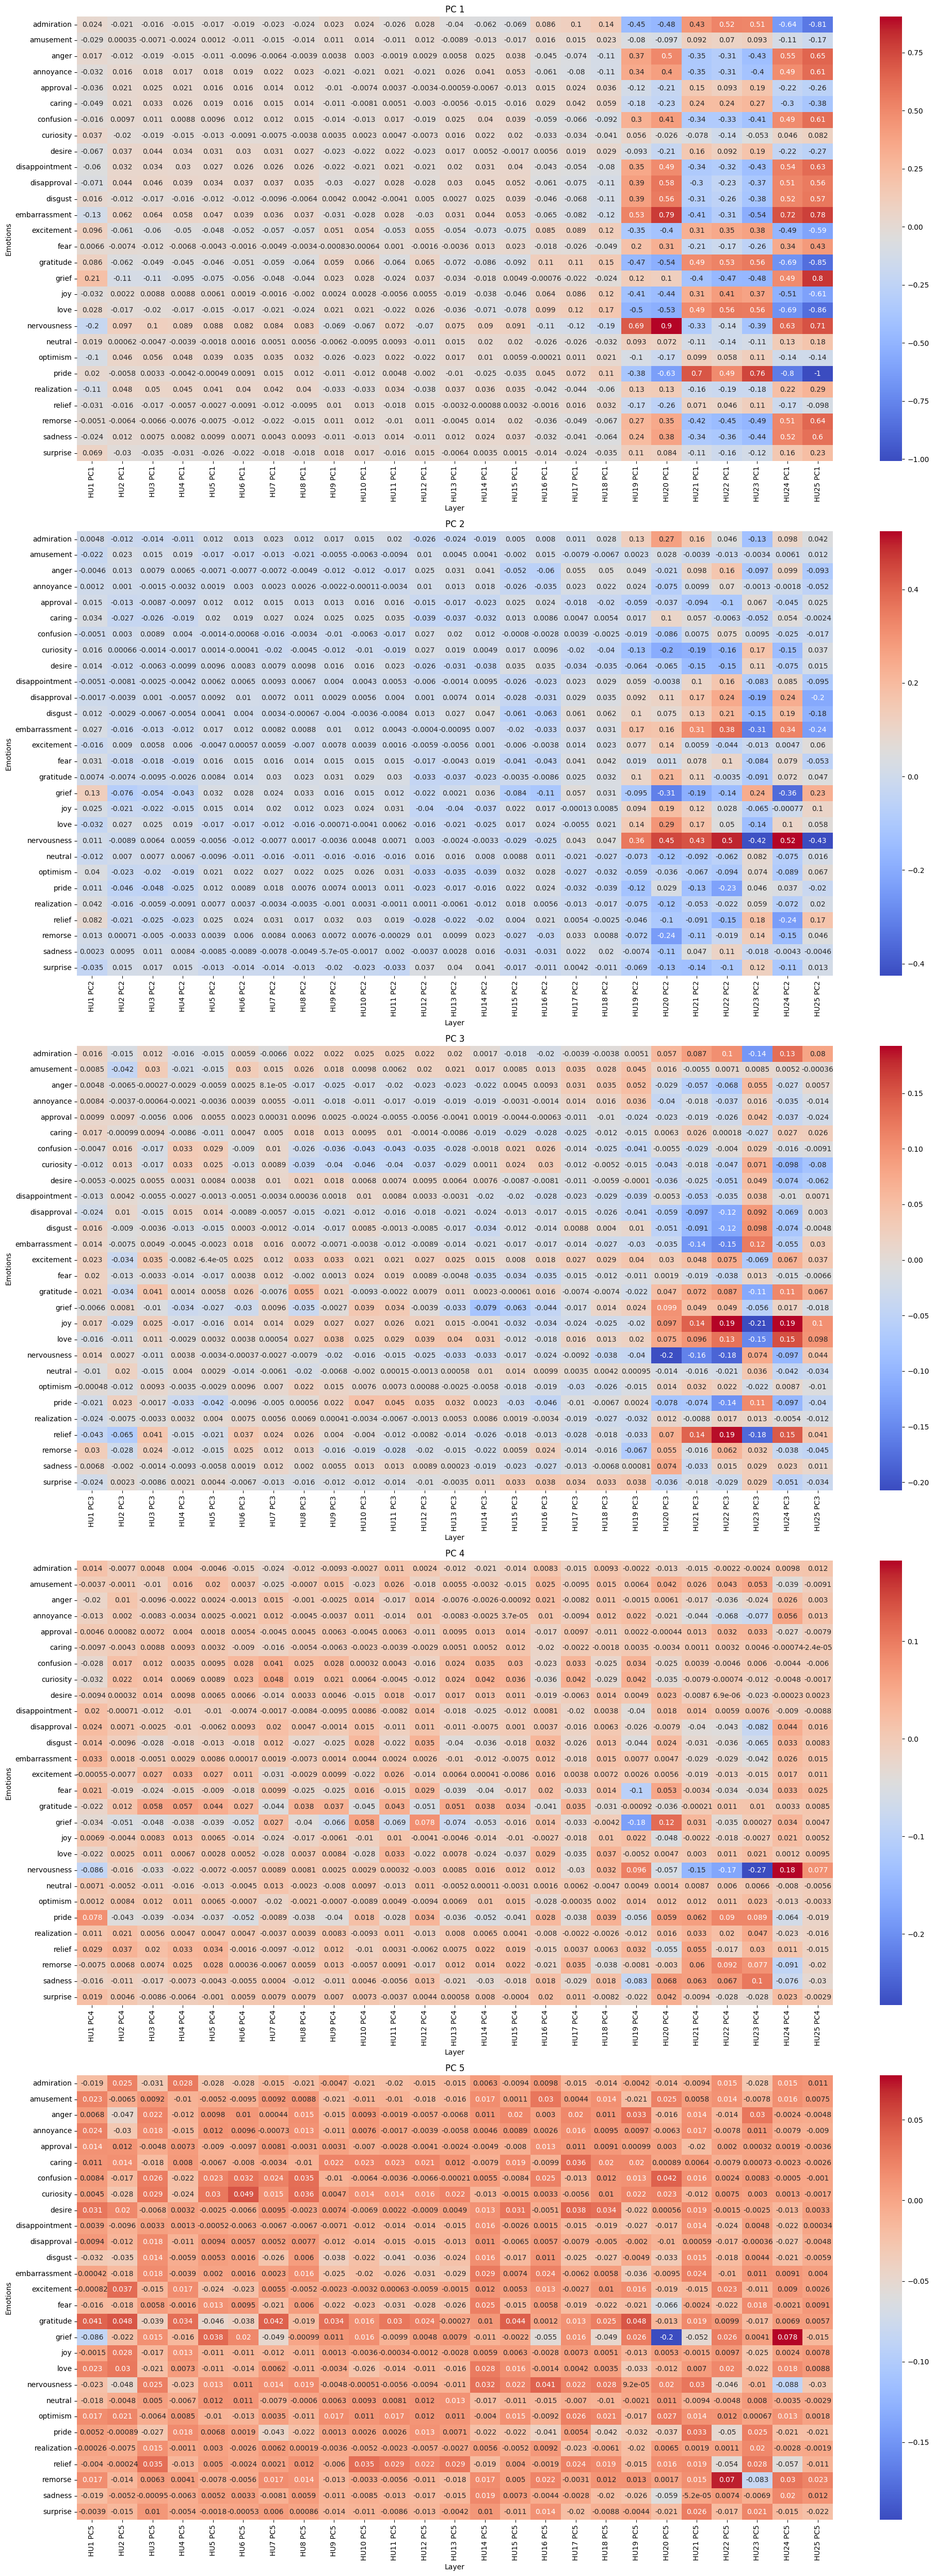

In [92]:
n_subplots = 5
fig, axes = plt.subplots(n_subplots, 1, figsize=(20, 50))

for i in range(n_subplots):
    component_indices = np.arange(0, 25*n_components, 5) + i
    data = mean_pcs.iloc[:, component_indices]
    sns.heatmap(data, cmap='coolwarm', annot=True, ax=axes[i])
    axes[i].set_title(f'PC {i+1}')
    axes[i].set_xlabel('Layer')
    axes[i].set_ylabel('Emotions')

plt.tight_layout()
plt.show()


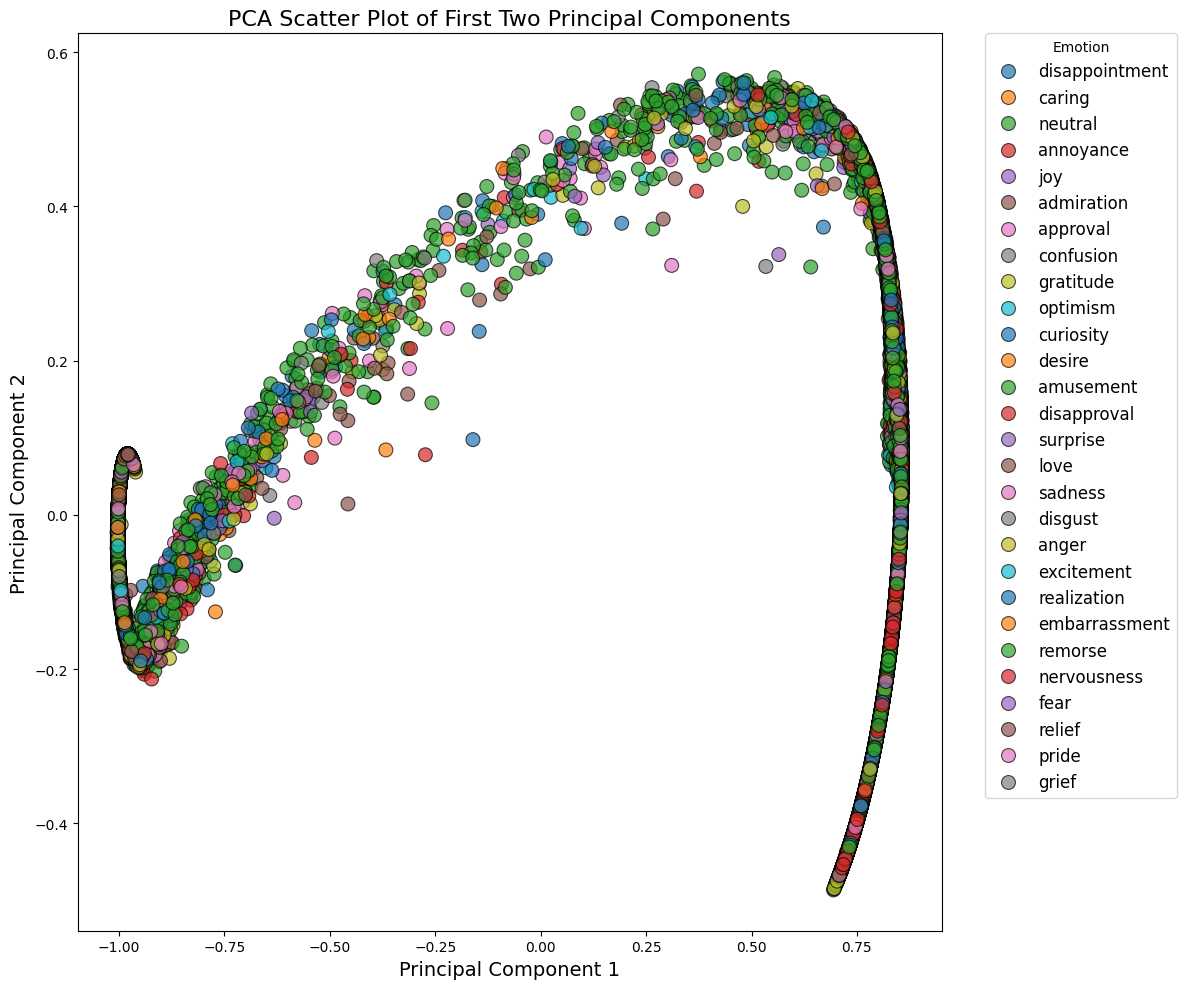

In [55]:
plt.figure(figsize=(12, 10))

# Create the scatter plot
scatter = sns.scatterplot(
    data=pc_df,
    x='PC1',
    y='PC2',
    hue='Emotion_Name',
    palette='tab10',
    alpha=0.7,
    edgecolor='k',
    s=100  
)

plt.title('PCA Scatter Plot of First Two Principal Components', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)


plt.legend(
    title='Emotion',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0,
    fontsize=12
)

plt.tight_layout()
plt.show()


Hmmm, it looks like a projection of some connected object from higher dim that curves on dim=2?

In [56]:
from sklearn.decomposition import FactorAnalysis

n_factors = 30  # Or another number based on your analysis
fa = FactorAnalysis(n_components=n_factors, random_state=42)
factors = fa.fit_transform(embeddings_np)

# Create DataFrame with factors
factor_columns = [f'Factor_{i+1}' for i in range(n_factors)]
factor_df = pd.DataFrame(factors, columns=factor_columns)
factor_df['Emotion_Name'] = pc_df['Emotion_Name']


In [26]:
mean_factor = factor_df.groupby('Emotion_Name')[factor_columns].mean()

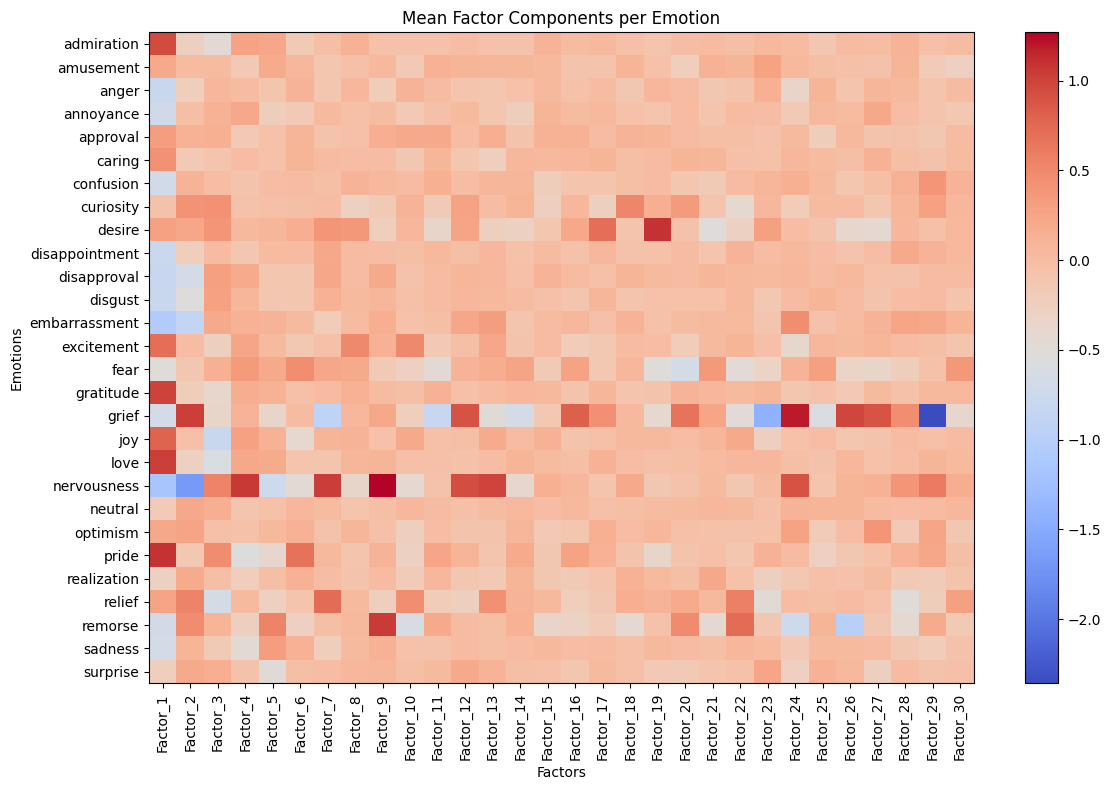

In [29]:
plt.figure(figsize=(12, 8))
plt.imshow(mean_factor.values, aspect='auto', cmap='coolwarm')
plt.xticks(ticks=np.arange(len(mean_factor.columns)), labels=mean_factor.columns, rotation=90)
plt.yticks(ticks=np.arange(len(mean_factor.index)), labels=mean_factor.index)
plt.xlabel('Factors')
plt.ylabel('Emotions')
plt.title('Mean Factor Components per Emotion')
plt.colorbar()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.decomposition import KernelPCA

n_components = 9  # Number of components to keep

pca = KernelPCA(n_components=n_components,  kernel='rbf')
principal_components = pca.fit_transform(embeddings_centered)
print(f"Principal components shape: {principal_components.shape}")


In [35]:
# Create a DataFrame
pc_columns = [f'PC{i+1}' for i in range(n_components)]
pc_df = pd.DataFrame(principal_components, columns=pc_columns)
pc_df['Emotion_Label'] = filtered_labels

# Get emotion names from the dataset
emotion_names = dataset['train'].features['labels'].feature.names

# Map labels to names
pc_df['Emotion_Name'] = pc_df['Emotion_Label'].apply(lambda x: emotion_names[x])
mean_pcs = pc_df.groupby('Emotion_Name')[pc_columns].mean()

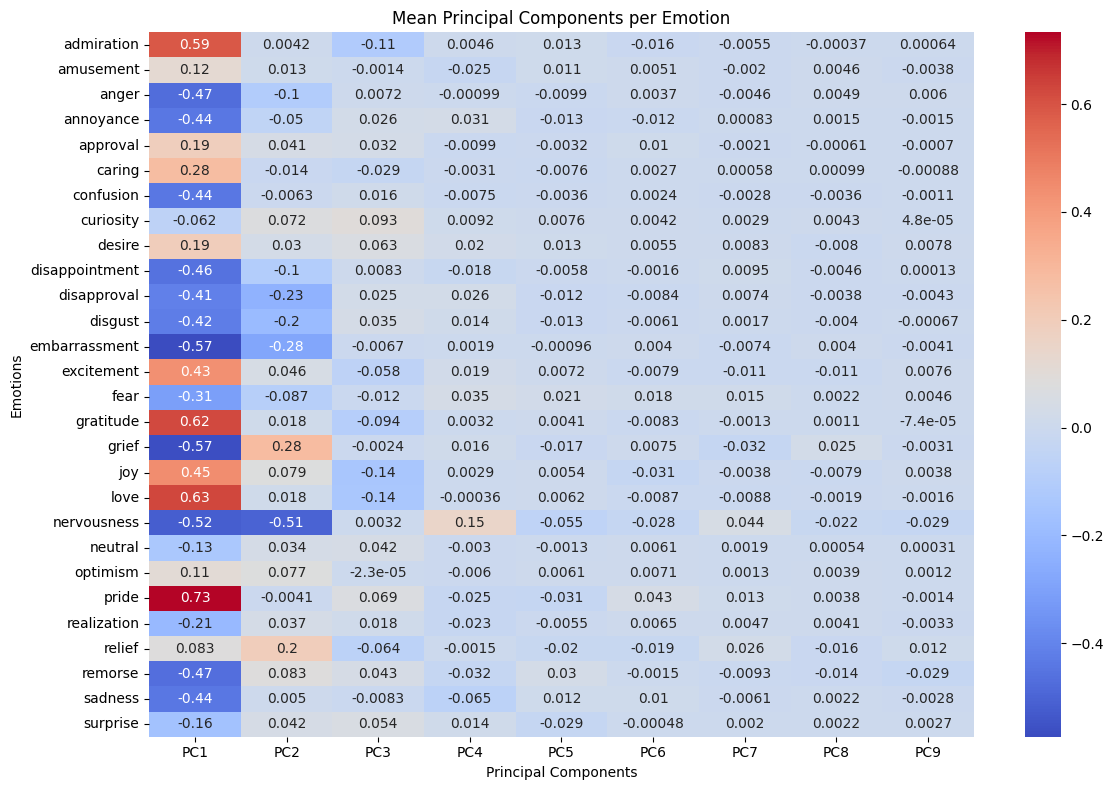

In [36]:
plt.figure(figsize=(12, 8))
sns.heatmap(mean_pcs, cmap='coolwarm', annot=True)
plt.title('Mean Principal Components per Emotion')
plt.xlabel('Principal Components')
plt.ylabel('Emotions')
plt.tight_layout()
plt.show()